In [35]:
%matplotlib inline

In [36]:
import sklearn
import xgboost
import vecstack
import dill

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [38]:
def read_df(filename, valtype):
    df = pd.read_csv(filename, low_memory=False, dtype=valtype)
    return df

In [39]:
from collections import OrderedDict, defaultdict

def create_combined_df(input_dict):
    fdf = pd.DataFrame()
    cols = OrderedDict()
    for k, v in input_dict.items():
        df = read_df('./data/'+k, v)
        colnames = [c for c in df.columns if c not in ['None', 'Unnamed: 0']]
        cols[k] = colnames
        fdf = pd.concat([fdf, df], axis=1)
    
    # fdf = fdf.DataFrame(fdf, columns=cols)
    fdf = fdf.drop(['None', 'Unnamed: 0'], axis=1)
    return fdf, cols

# Read Dependent feature data

In [40]:
base = './data/'

In [41]:
y_train = pd.read_csv(base+'fin_train_indeps.csv', encoding='utf8')
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_train.sample()

,review_scores_rating
9753,100.0


In [42]:
np.unique(y_train)

array([ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.])

In [43]:
y_test = pd.read_csv(base+'fin_test_indeps.csv', encoding='utf8')
y_test = y_test.drop(['Unnamed: 0'], axis=1)
y_test.sample()

,review_scores_rating
56129,100.0


In [44]:
np.unique(y_test)

array([ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.])

# Read independent feature data

In [45]:
comb_train = pd.read_csv(base+'fin_comb_train_deps.csv')
comb_train = comb_train.drop(['Unnamed: 0'], axis=1)
comb_test = pd.read_csv(base+'fin_comb_test_deps.csv')
comb_test = comb_test.drop(['Unnamed: 0'], axis=1)

# Split Test data into Holdout and Validation sets

In [46]:
np.random.seed(1234)
idxs = np.random.randint(0, y_test.shape[0], y_test.shape[0]//2)

In [48]:
y_validation = y_test.iloc[~y_test.index.isin(idxs)]
y_holdout = y_test.iloc[idxs]

In [49]:
comb_validation = comb_test.iloc[~comb_test.index.isin(idxs)]
comb_holdout = comb_test.iloc[idxs]

In [50]:
# Objective: Implement a wrapper for vecstack
# Input scikit model instances and training data
# Output: Predictions

import xgboost
import dill as pickle
from copy import deepcopy 
from vecstack import StackingTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib

class VecstackRunner():

    def __init__(self, X, y, Xt, yt, l1_estimators, l2_estimator, prfx='', metric='rmse', regression=True, nfolds=10, verbose=2):
        self.X = X
        self.y = y
        self.Xt = Xt
        self.yt = yt
        self.yp = None
        self.ytp = None
        self.l1 = l1_estimators
        self.l2 = l2_estimator
        self.prfx = prfx
        self.metname = metric
        self.nf = nfolds
        self.v = verbose
        self.is_reg = regression
        self.stack = None
    
    def mse(self, actual, pred):
        return mean_squared_error(actual, pred)
    
    def rsq(self, actual, pred):
        return r2_score(actual, pred)
    
    def get_metric_calc(self, actual, pred):
        if 'rmse' == self.metname:
            return self.mse(actual, pred)
        elif 'r2' == self.metname:
            return self.rsq(actual, pred)
    
    def build_stack(self):
        self.stack = StackingTransformer(self.l1, 
                                        regression=self.is_reg, 
                                        shuffle=True, 
                                        n_folds=self.nf, 
                                        metric=self.get_metric_calc, 
                                        verbose=self.v)
    
    def fit_stack(self):
        return self.stack.fit(self.X, self.y)
    
    def transform(self):
        self.X = self.stack.transform(self.X)
        self.Xt = self.stack.transform(self.Xt)
    
    def fit_l2(self):
        self.l2.fit(self.X, self.y)
    
    def predict(self):
        self.yp = self.l2.predict(self.X)
        self.ytp = self.l2.predict(self.Xt)
    
    def calculate_error(self, calc=None):
        if calc:
            y_err = calc(self.y, self.yp)
            yp_err = calc(self.y, self.ytp)
        else:
            y_err = self.get_metric_calc(self.y, self.yp)
            yt_err = self.get_metric_calc(self.yt, self.ytp)
            
        return [('Train err', y_err), ('Test err', yt_err)]
    
    def save_to_disk(self):
        sname = self.prfx+'_vecstack_stack.pkl'
        cname = self.prfx+'_vecstack_clf.pkl'
        
        with open('./data/'+sname, 'wb') as f:
            pickle.dump(self.stack,f)
        
        with open('./data/'+cname, 'wb') as f:
            pickle.dump(self.l2, f)
    
    def run(self):
        self.build_stack()
        self.fit_stack()
        self.transform()
        self.fit_l2()
        self.predict()
        self.save_to_disk()
        return self.calculate_error()

In [51]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

en = ElasticNet(alpha=0.01)
# lass = Lasso(alpha=0.001, fit_intercept=False, max_iter=1000)
ridge = Ridge(normalize=False, alpha=0.1, max_iter=1000)
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, 
                               subsample=0.75, max_depth=15)
ab = AdaBoostRegressor(n_estimators=100, learning_rate=0.01)
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.05, 
                           gamma=0, subsample=0.5, 
                           max_depth=15, objective='reg:linear')
randf = RandomForestRegressor(n_estimators=100, min_samples_split=10)
svr_rbf = SVR(kernel='rbf')

In [52]:
from copy import deepcopy

In [ ]:
estimators = [
                ('en', en), 
                # ('lass', lass), 
                ('ridge', ridge),
                ('gb', gb), 
                ('ab', ab), 
                ('randf', randf), 
             ]
base = './data/'
prf = 'comb'
vr = VecstackRunner(comb_train, y_train, 
                    comb_validation, y_validation, 
                    estimators, xgb, prfx=prf, nfolds=10)
vr.run()

# print mean_squared_error(y_validation, tc.predict(ts.transform(comb_validation)))

/Users/jhabib/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


task:         [regression]
metric:       [get_metric_calc]
variant:      [A]
n_estimators: [5]

estimator  0: [en: ElasticNet]
    fold  0:  [28.62955409]
    fold  1:  [23.46238485]
    fold  2:  [24.46192645]
    fold  3:  [23.80988442]
    fold  4:  [24.51719549]
    fold  5:  [27.19129348]
    fold  6:  [28.73117538]
    fold  7:  [24.46624948]
    fold  8:  [27.29496441]
    fold  9:  [23.36181634]
    ----
    MEAN:     [25.59264444] + [2.02295529]

estimator  1: [ridge: Ridge]


In [53]:
import dill as pickle

base='/mnt/f/Google Drive/flask_model_data/'
prf='comb'
with open(base+prf+'_vecstack_stack.pkl', 'rb') as f:
    ts = pickle.load(f)

with open(base+prf+'_vecstack_clf.pkl', 'rb') as f:
    tc = pickle.load(f)

In [54]:
Xt = ts.transform(comb_train)
Xp = tc.predict(Xt)
y = y_train

Train set was detected.
Transforming...

estimator  0: [en: ElasticNet]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: done
    model from fold  9: done
    ----
    DONE

estimator  1: [ridge: Ridge]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: done
    model from fold  9: done
    ----
    DONE

estimator  2: [gb: GradientBoostingRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
   

In [55]:
Xvt = ts.transform(comb_test)
Xvp = tc.predict(Xvt)
yv = y_test

Transforming...

estimator  0: [en: ElasticNet]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: done
    model from fold  9: done
    ----
    DONE

estimator  1: [ridge: Ridge]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: done
    model from fold  9: done
    ----
    DONE

estimator  2: [gb: GradientBoostingRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: don

In [56]:
print '####################'
print 'Column: %s' % prf
print 'Train: '
print 'MSE: %s' % mean_squared_error(y, Xp)
print 'R2: %s' % r2_score(y, Xp) 
print 'Test: '
print 'MSE: %s' % mean_squared_error(yv, Xvp)
print 'R2: %s' % r2_score(yv, Xvp)
print '####################\n'

####################
Column: comb
Train: 
MSE: 4.893748091484432
R2: 0.8072905642840638
Test: 
MSE: 5.750367354644492
R2: 0.768423312042936
####################



In [27]:
tc

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=15, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

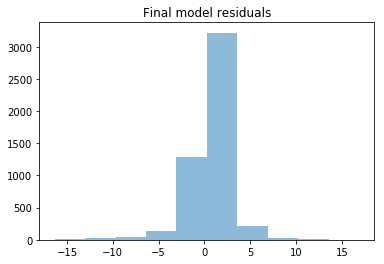

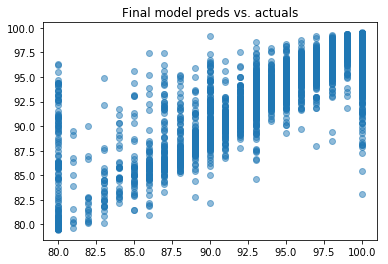

In [58]:
yv['preds'] = Xvp
s = yv.sample(5000)
plt.hist(s.review_scores_rating - s.preds, alpha=0.5)
plt.title('Final model residuals')
plt.show()
plt.scatter(s.review_scores_rating, s.preds, alpha=0.5)
plt.title('Final model preds vs. actuals')
plt.show()

In [59]:
yv.to_csv('./data/comb_stack_preds.csv', encoding='utf8')